# Árvores de regressão

## Índice <a name="topo"></a>

1. [intuição: Maximizando a gorjeta do garçom](#1)
2. [2. Medida de impureza](#2)
3. [3. Construindo a árvore](#3)
4. [4. Visualizando a árvore](#4)
5. [5. Visualizando a árvore](#4)
6. [6. Visualizando a árvore](#4)

In [1]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import tree
from dtreeviz import model

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

### 1. intuição: Maximizando a gorjeta do garçom<a name="1"></a>

Vamos ilustrar essa seção com o problema da gorjeta do garçom. Vamos montar uma árvore que tente explicar a variabilidade das gorjetas com base em variáveis que permitam montar uma estratégia para o garçom (assumindo que ele tenha uma certa liberdade pra escolher a mesa e o horário de trabalho). O sexo pode entrar como uma variável de controle. Para sexos diferentes podem fazer sentido estratégias diferentes - ou pelo menos pode-se conhecer uma eventual vantagem ou desvantagem na largada.

Note que o valor da conta não se conhece antes de escolher a mesa, portanto não é uma boa variável para se colocar no modelo com esta finalidade.

Quais variáveis mais discriminam a gorjeta? Pra responder a esta pergunta montamos um painelzinho abaixo.

<div style="text-align: right" 
     
[Voltar ao índice](#topo)

In [2]:
# Carrega o conjunto de dados 'tips' de exemplo do Seaborn
tips = sns.load_dataset("tips")

# Cria uma nova coluna 'tip_pct' que calcula a porcentagem da gorjeta sobre o valor do serviço (total_bill - tip)
tips['tip_pct'] = tips['tip'] / (tips['total_bill'] - tips['tip'])

# Exibe as primeiras 5 linhas do DataFrame atualizado
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.063204
1,10.34,1.66,Male,No,Sun,Dinner,3,0.191244
2,21.01,3.50,Male,No,Sun,Dinner,3,0.199886
3,23.68,3.31,Male,No,Sun,Dinner,2,0.162494
4,24.59,3.61,Female,No,Sun,Dinner,4,0.172069


c:\Users\earap\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
c:\Users\earap\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
c:\Users\earap\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
c:\Users\earap\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWa

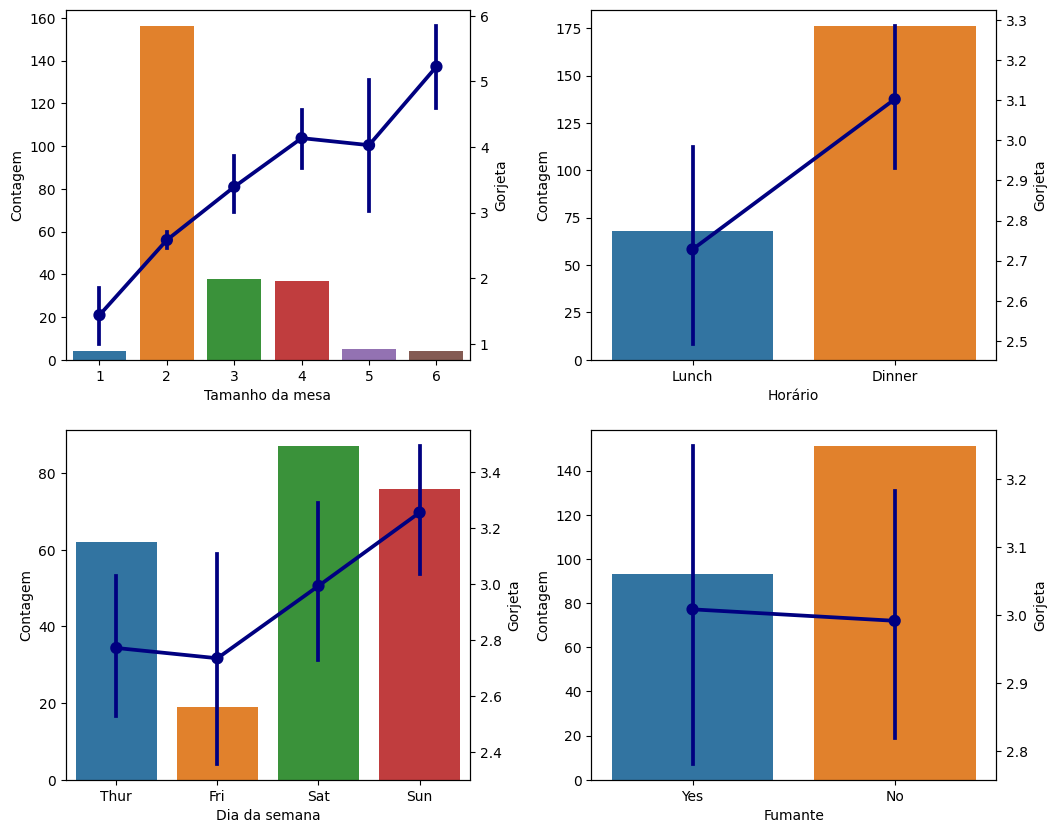

In [3]:
# Define o tamanho padrão das figuras para 12x10 polegadas
plt.rc('figure', figsize=(12, 10))

# Cria uma figura com 4 subplots organizados em 2 linhas e 2 colunas
fig, axes = plt.subplots(2, 2)

# Gráfico 1: tamanho da mesa
ax1 = axes[0,0]
sns.countplot(x="size", data=tips, dodge=True, ax=ax1)
ax1.set_ylabel("Contagem")
ax1.set_xlabel("Tamanho da mesa")

ax1b = ax1.twinx()
ax1b = sns.pointplot(x="size", y="tip", data=tips, dodge=True, errorbar=('ci', 90), color='navy')
plt.ylabel("Gorjeta")

# Gráfico 2: dia da semana
ax2 = axes[1,0]
sns.countplot(x="day", data=tips, dodge=True, ax=ax2)
ax2.set_ylabel("Contagem")
ax2.set_xlabel("Dia da semana")

ax2b = ax2.twinx()
ax2b = sns.pointplot(x="day", y="tip", data=tips, dodge=True, errorbar=('ci', 90), color='navy')
plt.ylabel("Gorjeta")

# Gráfico 3: horário
ax3 = axes[0,1]
sns.countplot(x="time", data=tips, dodge=True, ax=ax3)
ax3.set_ylabel("Contagem")
ax3.set_xlabel("Horário")

ax3b = ax3.twinx()
ax3b = sns.pointplot(x="time", y="tip", data=tips, dodge=True, errorbar=('ci', 90), color='navy')
plt.ylabel("Gorjeta")

# Gráfico 4: fumante
ax4 = axes[1,1]
sns.countplot(x="smoker", data=tips, dodge=True, ax=ax4)
ax4.set_ylabel("Contagem")
ax4.set_xlabel("Fumante")

ax4b = ax4.twinx()
ax4b = sns.pointplot(x="smoker", y="tip", data=tips, dodge=True, errorbar=('ci', 90), color='navy')
plt.ylabel("Gorjeta")

plt.subplots_adjust(wspace=.3, hspace=0.2)


### 2. Medida de impureza<a name="2"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)

Vamos estudar a variável tamanho da mesa, que parece explicar melhor que as demais a gorjeta.

C:\Users\earap\AppData\Local\Temp\ipykernel_14736\3421923283.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.



Text(0, 0.5, 'Resposta')

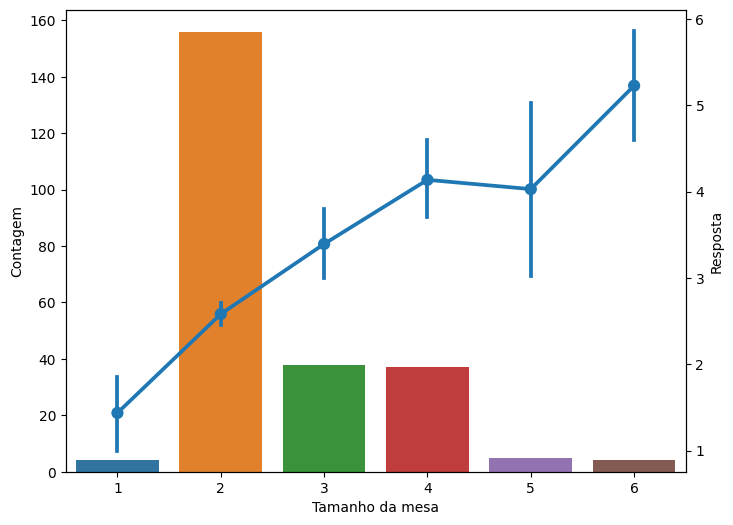

In [4]:
# Define o tamanho padrão das figuras para 8x6 polegadas
plt.rc('figure', figsize=(8, 6))

# Cria um gráfico de barras para contar o número de observações por tamanho de mesa no dataset 'tips'
ax = sns.countplot(x="size",
                   data=tips, dodge=True)
plt.ylabel("Contagem")
plt.xlabel("Tamanho da mesa")

# Cria um segundo eixo Y compartilhando o eixo X com o gráfico anterior
ax2 = ax.twinx()

# Cria um gráfico de pontos (pointplot) para mostrar a gorjeta média ('tip') por tamanho de mesa
# O parâmetro 'dodge=True' evita a sobreposição dos pontos, e 'ci=90' define o intervalo de confiança de 90%
ax2 = sns.pointplot(x="size", y="tip", data=tips, dodge=True, ci = 90)
plt.ylabel("Resposta")


#### Medidas de impureza

O que queremos fazer aqui é **explicar a variabilidade** da gorjeta com base nas variáveis que temos disponíveis.A medida mais popular de "impureza" da árvore é o **erro quadrático médio** (MSE - *mean square error* em ingês).

MSE = $\displaystyle\frac{1}{n}\sum_{ x \in c }(x_i - \hat{x})^2 $

Em qu e$\hat{x_i}$ é a estimativa de $x_i$, no caso a média da folha à qual $x_i$ pertence.

c:\Users\earap\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
c:\Users\earap\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
c:\Users\earap\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
c:\Users\earap\anaconda3\Lib\site-packages\seaborn\categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.0, 0.0)]) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the fa

Text(0.5, 0, 'Tamanho da mesa')

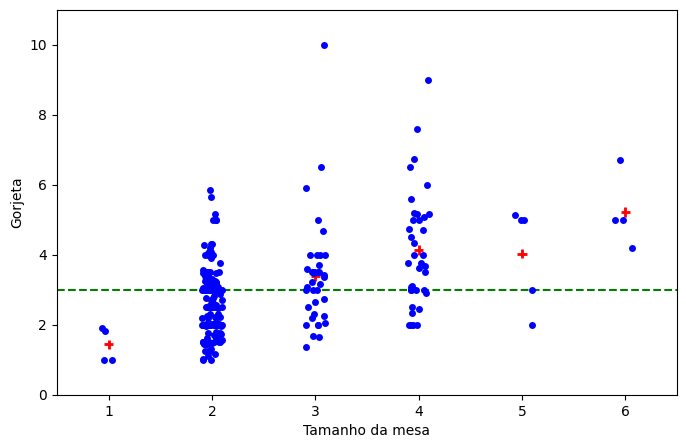

In [5]:
# Define o tamanho da figura para 8x5 polegadas
plt.rc('figure', figsize=(8, 5))

# Cria um gráfico do tipo stripplot mostrando a distribuição das gorjetas por tamanho de mesa
ax1 = sns.stripplot(x="size", 
                    y="tip", 
                    data=tips, 
                    color='blue')

# Define o limite do eixo Y entre 0 e 11
ax1.set(ylim=(0, 11))

# Adiciona uma linha horizontal no valor médio da gorjeta (tip) com estilo de linha pontilhada ('--') e cor verde
ax1.axhline(tips['tip'].mean(), 
            ls='--', 
            color = 'green')

# Reajusta o limite do eixo Y entre 0 e 11 novamente (opcional, repetido)
ax1.set(ylim=(0, 11))

# Adiciona um gráfico do tipo pointplot sobre o stripplot, mostrando os pontos médios de gorjeta por tamanho de mesa
# A cor é definida como vermelha ('red'), sem linhas de conexão ('linestyles=''') e com marcadores de '+' 
ax1 = sns.pointplot(x="size", 
                    y="tip", 
                    data=tips, 
                    color='red', 
                    errorbar = None, 
                    linestyles='', 
                    markers='+')

ax1.set_ylabel("Gorjeta")
ax1.set_xlabel("Tamanho da mesa")

A célula abaixo calcula o erro quadrático médio para cada possível quebra da árvore. Não precisa se preocupar tanto com esse código, já que o scikitlearn já faz essa conta pra nós. Aqui está mais para ilustrarmos como o algoritmo vai fazer para procurar a melhor quebra.

In [6]:
quebra = 2

EQM = []
for quebra in range(tips['size'].max() + 1):
    grupos = pd.cut(tips['size']
                    , bins = [-1, quebra, 99]
                    , labels = ['0 a ' + str(quebra), str(quebra) + ' ou mais'])

    tips_ = tips.copy()
    tips_['grupo'] = grupos

    tips_ = tips_.merge(tips_[['tip', 'grupo']].groupby('grupo').mean()
                        , on = 'grupo'
                        , how = 'left')

    # tips_
    tips_['EQ'] = (tips_['tip_x'] - tips_['tip_y'])**2
    EQM.append(tips_['EQ'].mean())


["{:5.2f}".format(x) for x in EQM]


C:\Users\earap\AppData\Local\Temp\ipykernel_14736\1759459922.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\earap\AppData\Local\Temp\ipykernel_14736\1759459922.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\earap\AppData\Local\Temp\ipykernel_14736\1759459922.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\earap\AppData\Local\Temp\ipykernel_14736\1759459922.py:12: FutureWarning: The d

[' 1.91', ' 1.87', ' 1.53', ' 1.56', ' 1.81', ' 1.82', ' 1.91']

Vemos abaixo que o menor EQM está na quebra **size > 2**.

Text(0.5, 0, 'Tamanho da mesa < X')

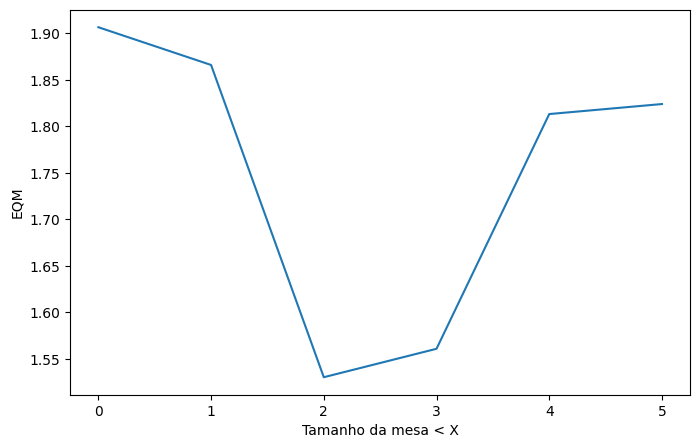

In [7]:
fig = plt.figure()

plt.plot(EQM[0:6])
plt.ylabel("EQM")
plt.xlabel("Tamanho da mesa < X")

### 3. Construindo a árvore<a name="3"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)

#### Dividindo a base em treino e teste

Já vimos que um perigo grande de um algoritmo é o *overfitting*, ou "o algoritmo aprender os dados". Isso significa que o algoritmo não fica geral o suficiente para ser aplicado em uma situação prática. Vimos também que uma forma interessante de evitar isto é dividir a base em uma parte de treinamento, e outra de teste, de modo que podemos avaliar o algoritmo na base de testes, e até fazer algumas modificações no algoritmo com essa base.

Vamos repetir esse passo diversas vezes ainda, então vamos lá:
- vamos colocar a variável "tip" como variável resposta (y)
- as demais variáveis são as preditoras, vão ficar no objeto X.

Lembre-se de que o Scikitlearn não aceita variáveis string nem *missing*. Nesse caso vamos precisar do "get_dummies" para transformar as variáveis qualitativas em variáveis indicadoras, ou variáveis *dummy*.

In [8]:
# Remove as colunas 'total_bill', 'tip', e 'tip_pct' do DataFrame 'tips' e faz uma cópia
X = tips.drop(columns = ['total_bill', 'tip', 'tip_pct']).copy()

# Converte variáveis categóricas em variáveis dummy, removendo a primeira categoria para evitar multicolinearidade
X = pd.get_dummies(X, drop_first = True)

print(X.info())

X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   size         244 non-null    int64
 1   sex_Female   244 non-null    bool 
 2   smoker_No    244 non-null    bool 
 3   day_Fri      244 non-null    bool 
 4   day_Sat      244 non-null    bool 
 5   day_Sun      244 non-null    bool 
 6   time_Dinner  244 non-null    bool 
dtypes: bool(6), int64(1)
memory usage: 3.5 KB
None


,size,sex_Female,smoker_No,day_Fri,day_Sat,day_Sun,time_Dinner
0,2,True,True,False,False,True,True
1,3,False,True,False,False,True,True
2,3,False,True,False,False,True,True
3,2,False,True,False,False,True,True
4,4,True,True,False,False,True,True


In [9]:
# Seleciona a coluna 'tip' do DataFrame 'tips' como a variável dependente 'y'
y =  tips.loc[:,'tip']

y.head()

0    1.01
1    1.66
2    3.50
3    3.31
4    3.61
Name: tip, dtype: float64

In [10]:
# Divide o conjunto de dados em conjuntos de treinamento e teste
# 'X' e 'y' são as variáveis independentes e dependentes, respectivamente
# 'random_state' é definido para garantir a reprodutibilidade dos resultados

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2360873)

In [11]:
# Cria dois modelos de regressão de árvore de decisão com diferentes profundidades máximas
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=8)

# Ajusta os modelos aos dados de treinamento
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8)

In [12]:
# Calcula o R² (coeficiente de determinação) para os modelos ajustados usando o conjunto de treinamento
# mse1 = mean_squared_error(y_test, regr_1.predict(X_test))
mse1 = regr_1.score(X_train, y_train)
mse2 = regr_2.score(X_train, y_train)

template = "O MSE da árvore com profundidade={0} é: {1:.2f}"

# Exibe o R² para cada modelo, substituindo pontos por vírgulas na formatação
print(template.format(regr_1.get_depth(),mse1).replace(".",","))
print(template.format(regr_2.get_depth(),mse2).replace(".",","))


O MSE da árvore com profundidade=2 é: 0,23
O MSE da árvore com profundidade=7 é: 0,39


MSE (Erro Quadrático Médio)
Definição: O MSE mede a média dos quadrados dos erros, ou seja, a diferença média entre os valores previstos pelo modelo e os valores reais.

* Interpretação: Um MSE menor indica um melhor ajuste do modelo aos dados. O MSE penaliza mais os erros maiores, pois os erros são elevados ao quadrado.

R² (Coeficiente de Determinação)
Definição: O R² mede a proporção da variabilidade na variável dependente que é explicada pelo modelo. Ele fornece uma indicação de quão bem os dados se ajustam ao modelo de regressão.

* R² varia entre 0 e 1.
* R² próximo de 1 indica que uma grande proporção da variabilidade dos dados é explicada pelo modelo.
* R² próximo de 0 indica que o modelo não explica bem a variabilidade dos dados.
* Um R² negativo pode ocorrer se o modelo for muito inadequado e pior que a média dos valores.

### 4. Visualizando a árvore<a name="4"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)
     
Vamos ver três formas de visualizar a árvore:
     1. Visualizar a forma gráfica da árvore com plot_tree
     2. Visualizar a árvore com graphviz
     2. Representação impressa da árvore
     3. 

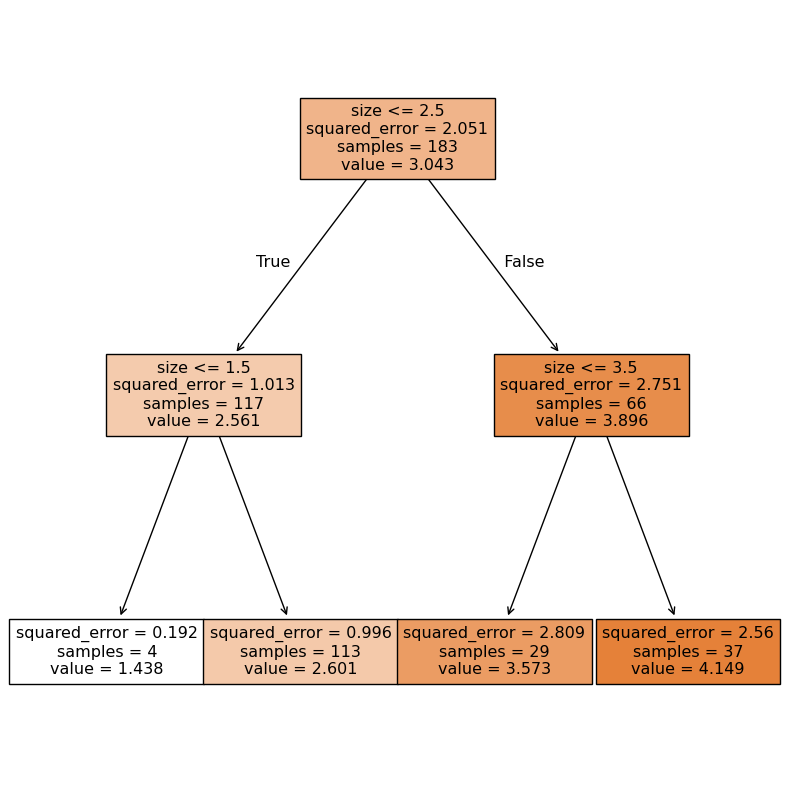

In [13]:
plt.rc('figure', figsize=(10, 10))

# Plota a árvore de decisão ajustada no modelo 'regr_1'
# 'feature_names' especifica os nomes das características para etiquetar os nós
# 'filled=True' preenche os nós com cores para representar as classes ou valores de previsão
tp = tree.plot_tree(regr_1, 
                    feature_names=X.columns,  
                    filled=True) 

#### Visualização da forma impressa da árvore

A árvore de regressão pode ser expressa na forma impressa, regra a regra com o comando abaixo:

In [14]:
representacao_textual = tree.export_text(regr_1)
print(representacao_textual)

|--- feature_0 <= 2.50
|   |--- feature_0 <= 1.50
|   |   |--- value: [1.44]
|   |--- feature_0 >  1.50
|   |   |--- value: [2.60]
|--- feature_0 >  2.50
|   |--- feature_0 <= 3.50
|   |   |--- value: [3.57]
|   |--- feature_0 >  3.50
|   |   |--- value: [4.15]



#### Instalando o graphviz e o dtreeviz

Ambos os pacotes não são essenciais para o nosso curso, mas fornecem recursos interessantes de visualização de árvores. Não cobriremos em detalhes a instalação desses pacotes, mas as instruções se encontram nesse [link](https://github.com/parrt/dtreeviz)

In [15]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'


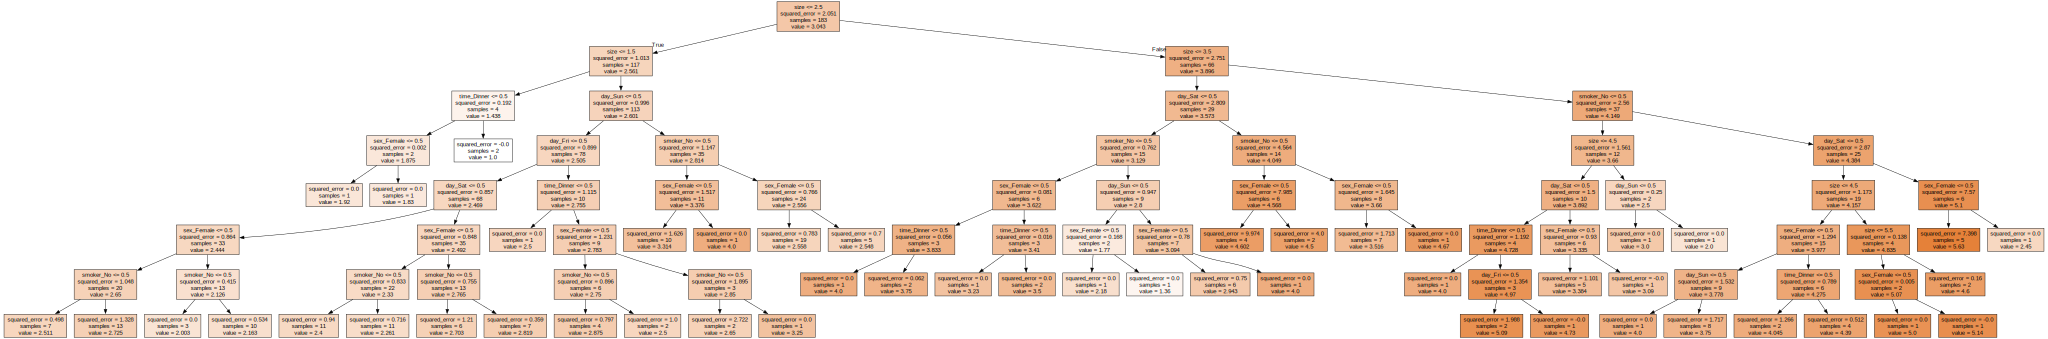

In [16]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(regr_2, out_file=None, 
                                feature_names=X.columns,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

c:\Users\earap\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


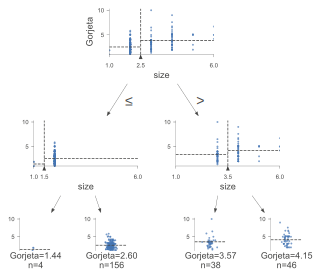

In [17]:
# Atualiza as configurações globais do Matplotlib para tamanho e fonte da figura
plt.rcParams.update({'figure.figsize': (22.0, 18.0)})
plt.rcParams.update({'font.size': 14})


# Cria o modelo de visualização usando o 'regr_1' e os dados
# 'target_name' especifica o nome do alvo e 'feature_names' são os nomes das características
m = model(regr_1, X, y,
          target_name="Gorjeta",
          feature_names=X.columns)

# Visualizar o modelo
m.view()

###  5. Pré-poda<a name="5"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)
     

In [18]:
# Cria e ajusta um modelo de regressão de árvore de decisão com profundidade máxima de 3 e mínimo de 10 amostras por folha
regr_1 = DecisionTreeRegressor(max_depth=4, min_samples_leaf=5)

# Ajusta o modelo aos dados de treinamento
regr_1.fit(X_train, y_train)

# Avalia o modelo usando o conjunto de teste
# A função 'score' retorna o R² (coeficiente de determinação), que mede a qualidade do ajuste
mse1 = regr_1.score(X_test, y_test)

# Exibe o R² do modelo no conjunto de teste
mse1

0.25325795309170984

n_minimo,5,6,7,8,9,10,11,12,13,14,...,20,21,22,23,24,25,26,27,28,29
profundidade,,,,,,,,,,,,,,,,,,,,,
1,0.169952,0.169952,0.169952,0.169952,0.169952,0.169952,0.169952,0.169952,0.169952,0.169952,...,0.169952,0.169952,0.169952,0.169952,0.169952,0.169952,0.169952,0.169952,0.169952,0.169952
2,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,...,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370,0.259370
3,0.239238,0.239238,0.239238,0.239238,0.239238,0.239238,0.239238,0.245591,0.251084,0.251084,...,0.257513,0.257513,0.257513,0.257513,0.257513,0.257513,0.257513,0.257513,0.257513,0.257513
4,0.253258,0.240488,0.241253,0.241253,0.241253,0.241253,0.241253,0.232992,0.237770,0.237770,...,0.246054,0.246054,0.246054,0.257805,0.257513,0.257513,0.257513,0.257513,0.257513,0.257513
5,0.216256,0.210044,0.229503,0.236062,0.229503,0.229503,0.229503,0.228870,0.237770,0.237770,...,0.246054,0.246054,0.246054,0.257805,0.257513,0.257513,0.257513,0.257513,0.257513,0.257513
6,0.192430,0.179660,0.205677,0.227590,0.227590,0.221031,0.221031,0.228870,0.237770,0.237770,...,0.246054,0.246054,0.246054,0.257805,0.257513,0.257513,0.257513,0.257513,0.257513,0.257513
7,0.192430,0.186827,0.212844,0.221031,0.227590,0.221031,0.221031,0.228870,0.237770,0.237770,...,0.246054,0.246054,0.246054,0.257805,0.257513,0.257513,0.257513,0.257513,0.257513,0.257513
8,0.199597,0.179660,0.212844,0.227590,0.227590,0.221031,0.221031,0.228870,0.237770,0.237770,...,0.246054,0.246054,0.246054,0.257805,0.257513,0.257513,0.257513,0.257513,0.257513,0.257513


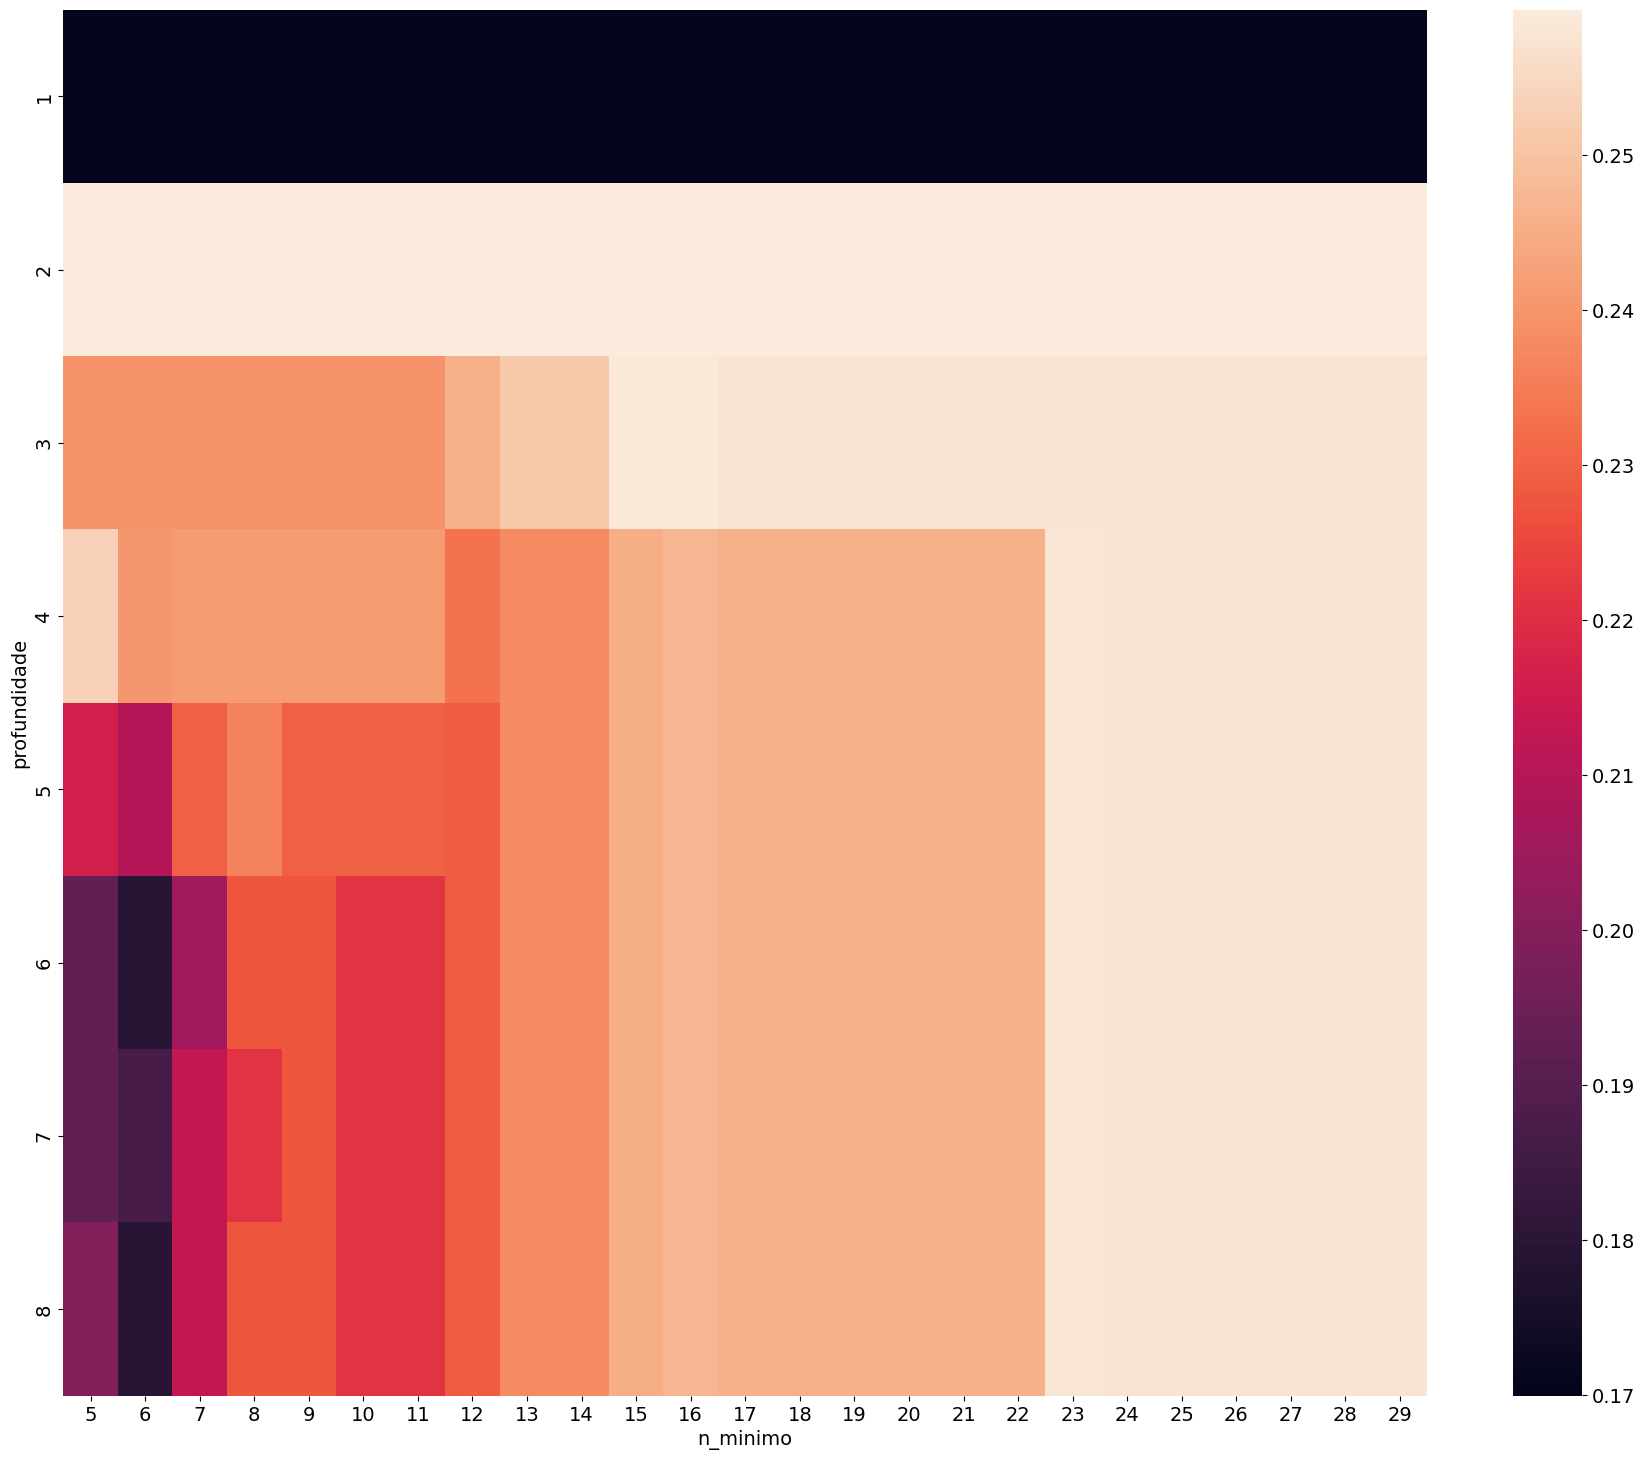

In [19]:
# Listas para armazenar os valores de R² e os parâmetros da árvore
mses = []
ind_i = []
ind_j = []

# Loop para testar diferentes combinações de profundidade e número mínimo de amostras por folha
for i in range(1, 9): # profundidade varia de 2 a 8
    for j in range(5, 30):  # número mínimo de amostras varia de 2 a 9
        # Cria e ajusta o modelo de árvore de decisão com os parâmetros atuais
        regr_1 = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j)
        regr_1.fit(X_train, y_train)

        # Avalia o modelo no conjunto de teste
        mse1 = regr_1.score(X_test, y_test)

        # Armazena os resultados
        mses.append(mse1)
        ind_i.append(i)
        ind_j.append(j)

# Cria um DataFrame para armazenar os resultados        
df_mse = pd.DataFrame({'mses':mses, 'profundidade':ind_i, 'n_minimo':ind_j})

# Cria um mapa de calor para visualizar o R² em função dos parâmetros
sns.heatmap(df_mse.pivot(index='profundidade', columns='n_minimo', values='mses'))

# Exibe o DataFrame com os resultados para inspeção
df_mse.pivot(index='profundidade', columns='n_minimo', values='mses')

### 6. Pós-poda<a name="6"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)
     

In [29]:
# Obtém o caminho de complexidade de custo de poda para o modelo 'regr_2'
# 'cost_complexity_pruning_path' retorna um objeto que contém o caminho de poda de complexidade de custo
path = regr_2.cost_complexity_pruning_path(X_train, y_train)

# Exibe o caminho de poda que inclui o parâmetro alpha e a complexidade do custo correspondente
path

{'ccp_alphas': array([0.00000000e+00, 2.34900777e-06, 2.21311475e-05, 7.65482696e-05,
        2.14387998e-04, 3.94808743e-04, 1.46894353e-03, 2.33778440e-03,
        2.73224044e-03, 3.90550590e-03, 4.18374317e-03, 6.37064793e-03,
        1.27133065e-02, 1.40943130e-02, 1.54579755e-02, 2.01481897e-02,
        2.15387295e-02, 2.85768555e-02, 3.04630024e-02, 3.14966462e-02,
        4.10774125e-01]),
 'impurities': array([1.29579051, 1.29579286, 1.29581499, 1.29589154, 1.29610593,
        1.29650074, 1.29796968, 1.30030746, 1.3030397 , 1.30694521,
        1.31112895, 1.3174996 , 1.33021291, 1.35840153, 1.37385951,
        1.41415589, 1.45723335, 1.4858102 , 1.57719921, 1.6401925 ,
        2.05096663])}

* ``ccp_alphas``: Esta é uma lista de valores do parâmetro alpha para cada passo do caminho de poda. O parâmetro alpha controla a complexidade da árvore; valores maiores de alpha resultam em árvores mais podadas (menos complexas). O valor alpha é associado ao nível de complexidade de custo que se aplica à árvore durante a poda.

* ``impurities``: Esta é uma lista dos valores de impureza (ou erro) total da árvore para cada valor de alpha. A impureza é uma medida de quão "suja" é a árvore em relação à previsão correta. À medida que alpha aumenta e a árvore é mais podada, a impureza geralmente aumenta.

Text(0, 0.5, 'Impureza total das folhas')

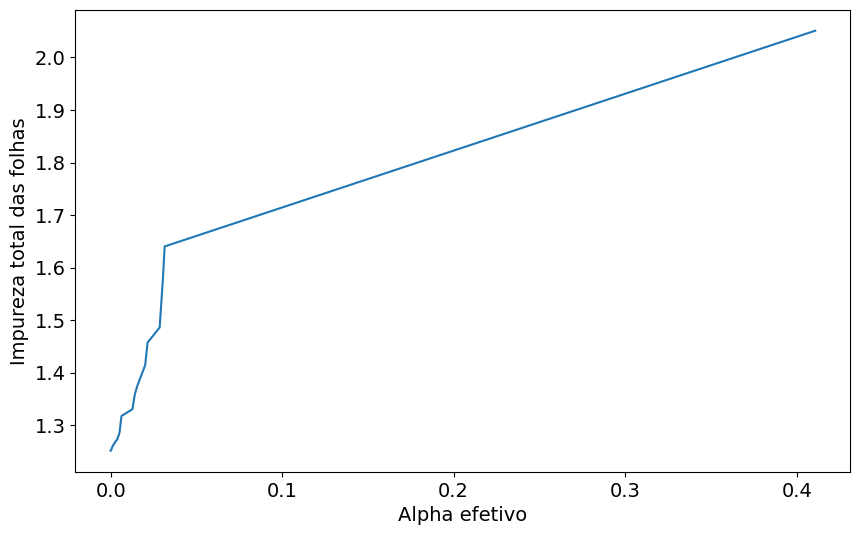

In [21]:
# Extraindo os valores de alpha efetivo e impureza total das folhas do caminho de poda
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Criar uma nova figura para o gráfico com o tamanho especificad
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("Alpha efetivo")
plt.ylabel("Impureza total das folhas")

In [22]:
# Inicializa uma lista vazia para armazenar os modelos de DecisionTreeRegressor.
clfs = []

# Itera sobre uma lista de valores de ccp_alpha (pode ser uma lista de diferentes valores para o parâmetro de poda).
for ccp_alpha in ccp_alphas:
    # Cria uma instância do DecisionTreeRegressor com um valor específico de ccp_alpha.
    # O ccp_alpha é um parâmetro de poda que controla a complexidade da árvore, ajudando a prevenir overfitting.
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    # Ajusta o modelo aos dados de treino (X_train e y_train).
    clf.fit(X_train, y_train)
    # Adiciona o modelo treinado à lista clfs.
    clfs.append(clf)

Text(0, 0.5, 'Profundidade da árvore')

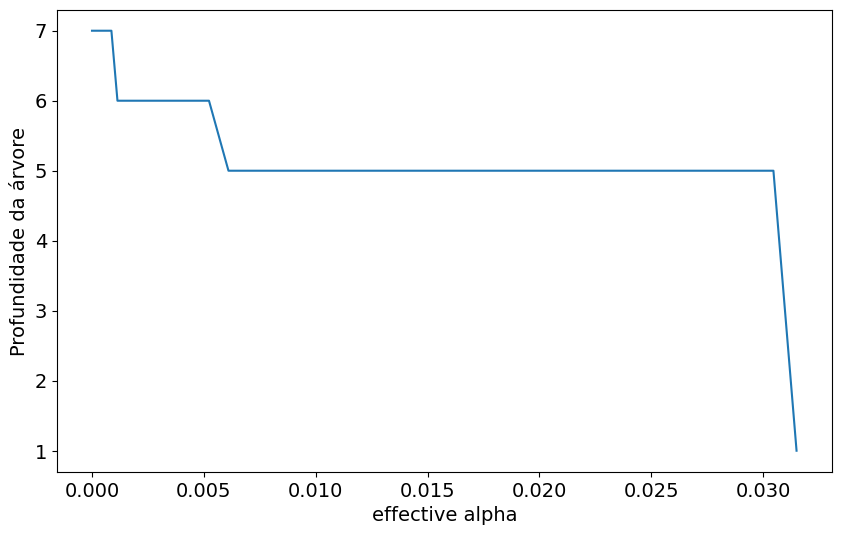

In [23]:
# Cria uma lista com as profundidades máximas das árvores para cada modelo treinado.
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Profundidade da árvore")

*Quando o valor de alpha é pequeno, a árvore pode ser mais complexa e mais propensa ao overfitting porque menos ramos são podados.

*Quando o valor de alpha é maior, mais ramos são podados, resultando em uma árvore mais simples que pode generalizar melhor, mas com um possível aumento no erro de treinamento.

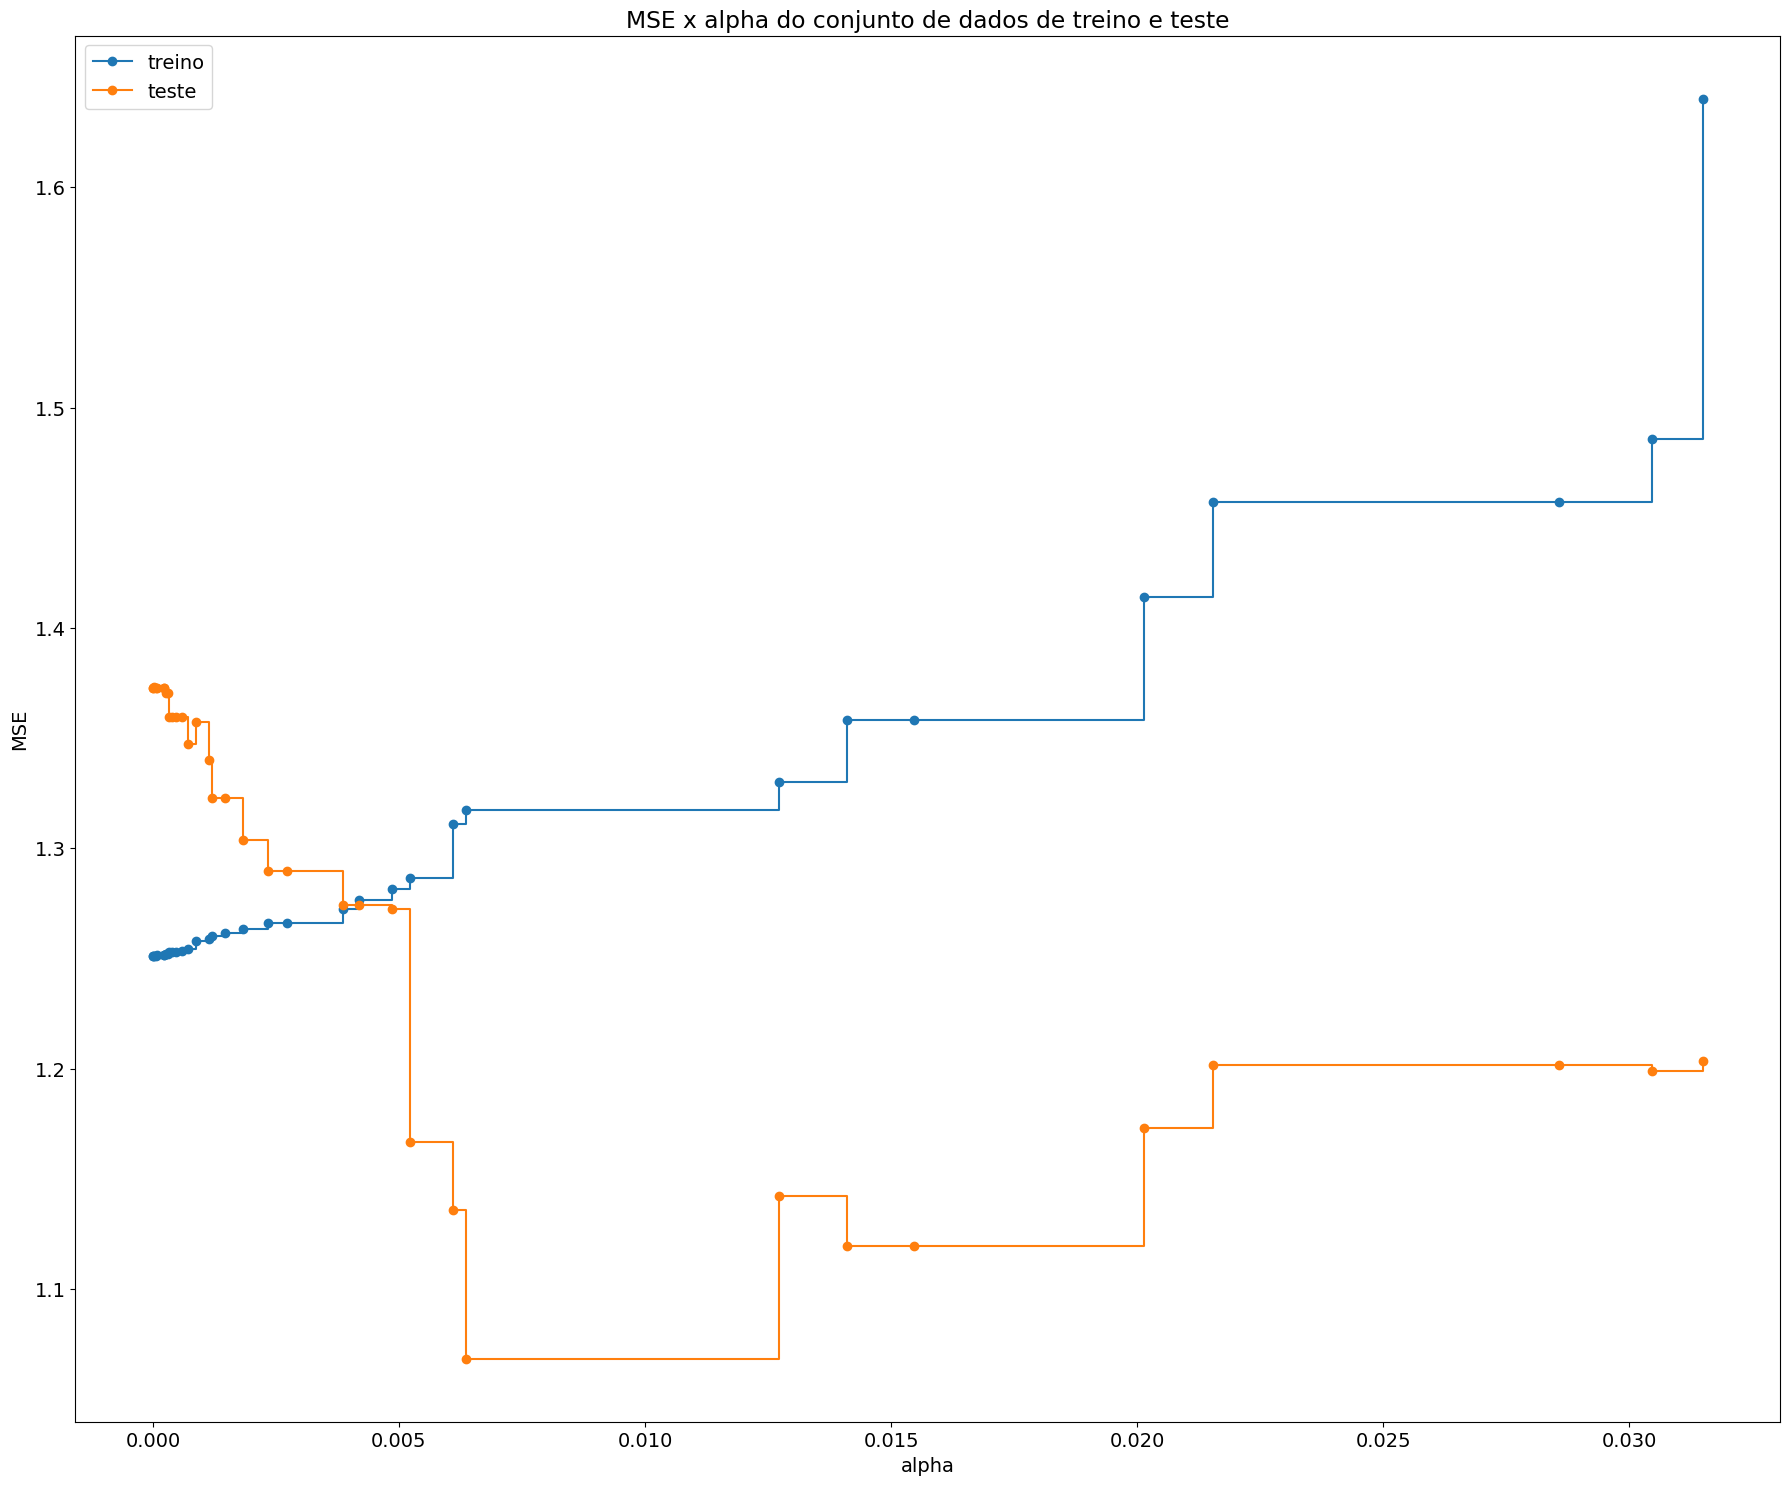

In [24]:
# Calcula o erro quadrático médio (MSE) para o conjunto de treino e o conjunto de teste
train_scores = [mean_squared_error(y_train , clf.predict(X_train)) for clf in clfs]
test_scores  = [mean_squared_error(y_test  , clf.predict(X_test )) for clf in clfs]

# Cria uma nova figura e um conjunto de eixos para o gráfico.
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x alpha do conjunto de dados de treino e teste")

# Plota o MSE do conjunto de treino em função de alpha.
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="treino",
        drawstyle="steps-post")
# Plota o MSE do conjunto de teste em função de alpha.
ax.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

#### Exemplo intuitivo de pós-poda

Exemplo do [scikitlearn](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py).

In [25]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

In [26]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

DecisionTreeRegressor(max_depth=5)

In [27]:
# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

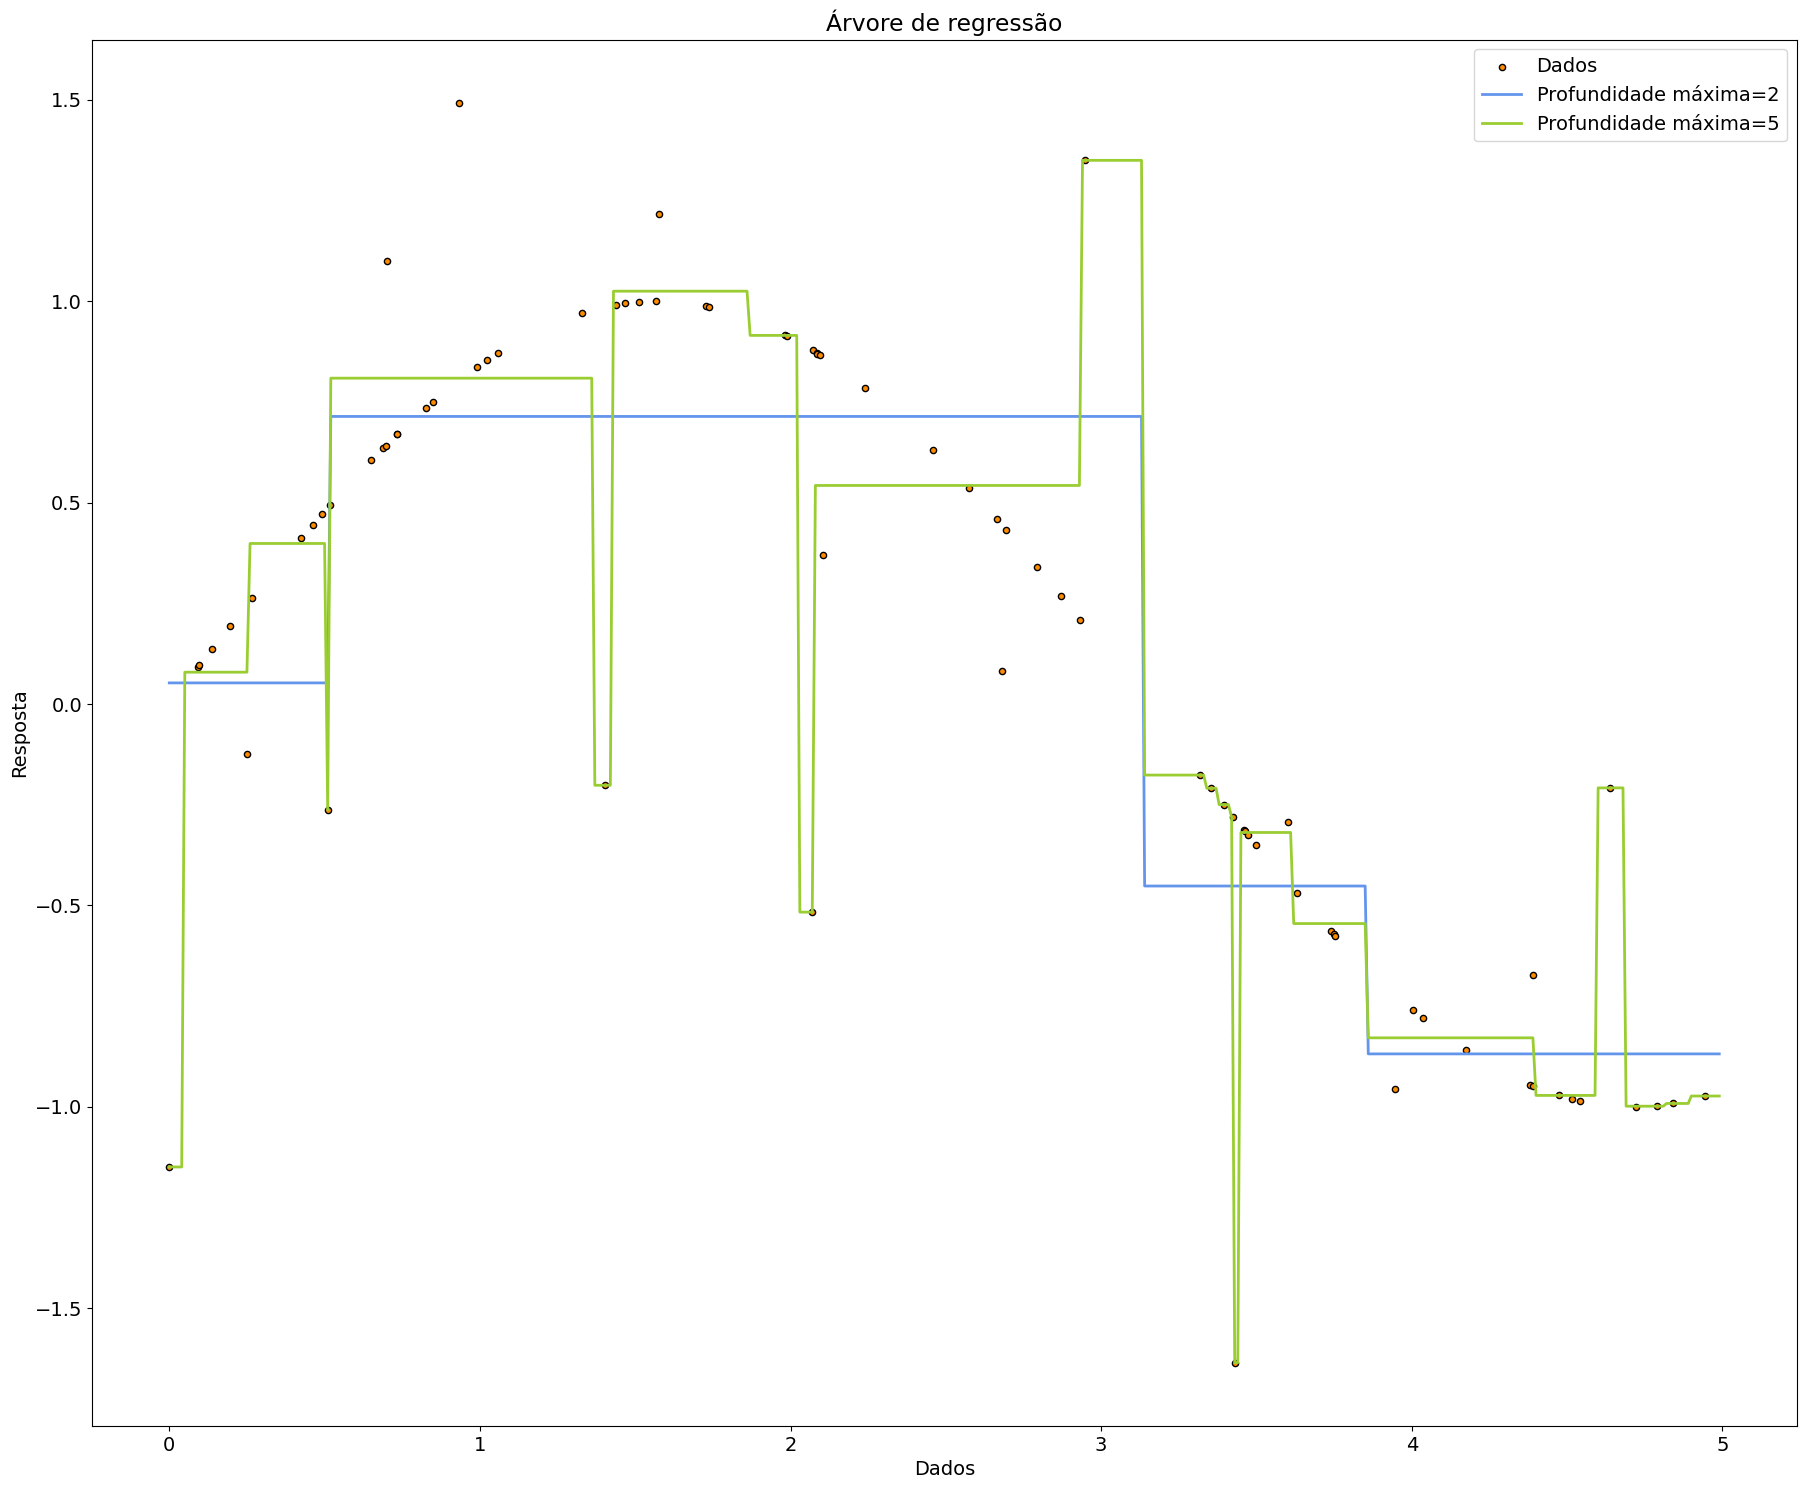

In [28]:
# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="Dados")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="Profundidade máxima=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="Profundidade máxima=5", linewidth=2)
plt.xlabel("Dados")
plt.ylabel("Resposta")
plt.title("Árvore de regressão")
plt.legend()
plt.show()